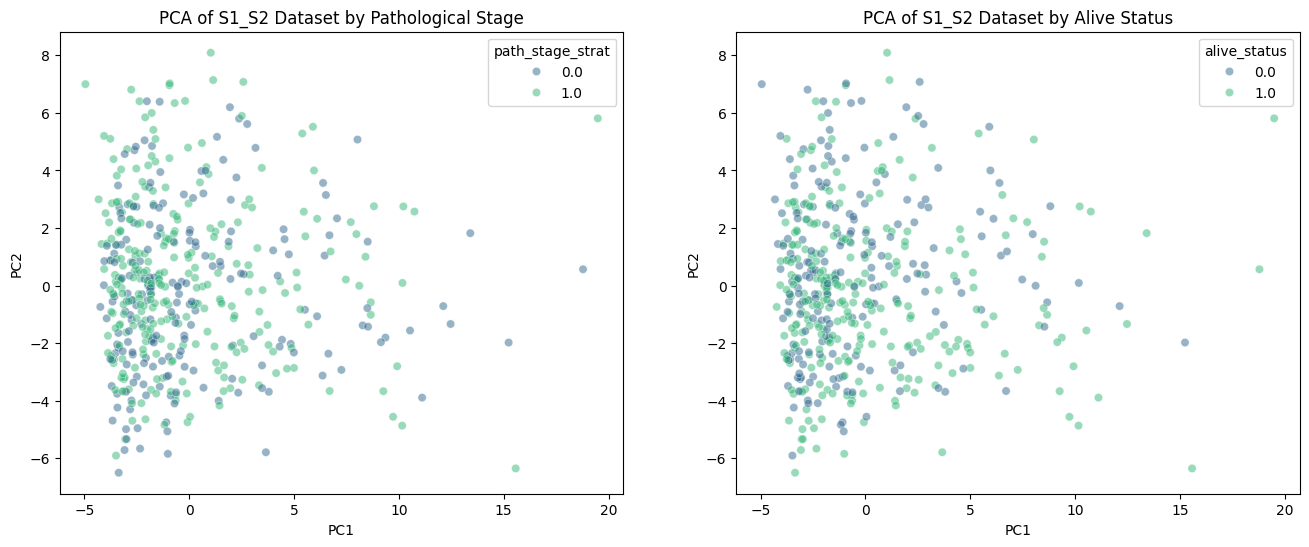

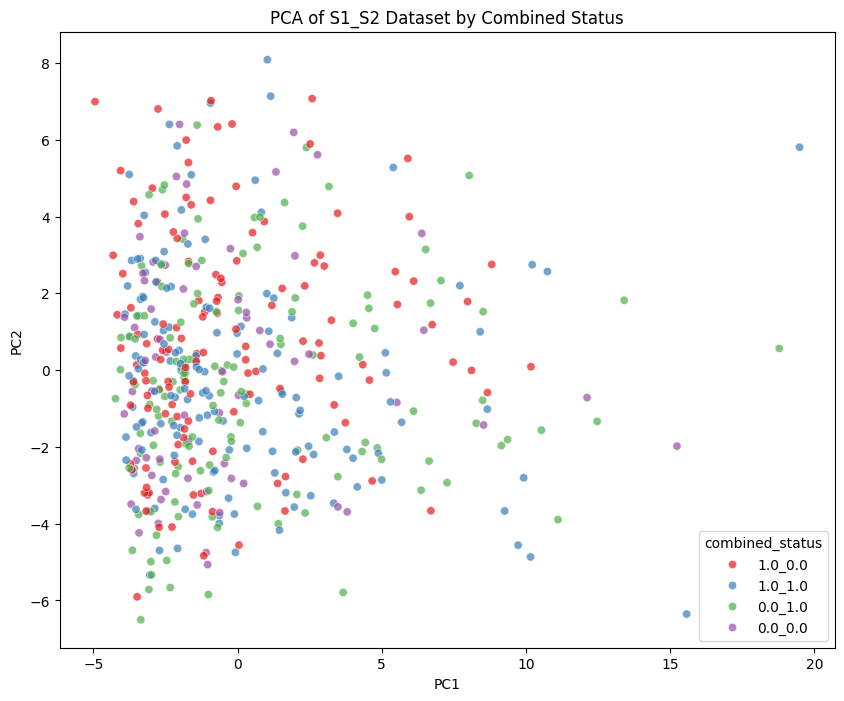

KeyError: 'file_id'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clinical_df = pd.read_csv('clinical.tsv', sep='\t')
clinical_df['path_stage_strat'] = clinical_df['ajcc_pathologic_stage'].replace("'--", np.NaN).map({'Stage I': 0, 'Stage II': 0, 'Stage III': 0, 'Stage IVA': 1, 'Stage IVB': 1, 'Stage IVC': 1})
conditions = [
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*3),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*3) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*5),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*5) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*10),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*10) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*20),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*20),
    (clinical_df['days_to_death'] == "'--") | (clinical_df['days_to_death'].isna())
]
values = [0, 0, 0, 1, 1, 1, 1]
clinical_df['alive_status'] = np.select(conditions, values)
clinical_df = clinical_df[['case_id', 'path_stage_strat', 'alive_status']]

file_to_case_df = pd.read_csv('file_to_case.tsv', sep='\t')
data_files = ['rnaseq_s1_s2.tsv', 'new_x_rnaseq_s1_s2.csv']
data_frame_names = ['S1_S2', 'new_S1_S2']

for data_file, name in zip(data_files, data_frame_names):
    df = pd.read_csv(data_file, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()
    
    df['combined_status'] = df['path_stage_strat'].astype(str) + "_" + df['alive_status'].astype(str)
    
    X = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, df[['path_stage_strat', 'alive_status', 'combined_status']].reset_index(drop=True)], axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(ax=axs[0], x='PC1', y='PC2', hue='path_stage_strat', data=finalDf, palette='viridis', alpha=0.5)
    axs[0].set_title(f'PCA of {name} Dataset by Pathological Stage')
    
    sns.scatterplot(ax=axs[1], x='PC1', y='PC2', hue='alive_status', data=finalDf, palette='viridis', alpha=0.5)
    axs[1].set_title(f'PCA of {name} Dataset by Alive Status')
    
    plt.show()
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='combined_status', data=finalDf, palette='Set1', alpha=0.7)
    plt.title(f'PCA of {name} Dataset by Combined Status')
    plt.show()
